## tutorial to simulate tissue simulation with transcriptomic profile sample from single cell

In [1]:
from pathlib import Path
import sys
import tifffile
import numpy as np

In [29]:
sys.path += ['/snap/pycharm-professional/348/plugins/python/helpers/pydev',
             '/snap/pycharm-professional/348/plugins/python/helpers/third_party/thriftpy', 
             '/snap/pycharm-professional/348/plugins/python/helpers/pydev',
             '/snap/pycharm-professional/348/plugins/python/helpers/pycharm_display', 
             '/home/tom/anaconda3/envs/simulation/lib/python38.zip',
             '/home/tom/anaconda3/envs/simulation/lib/python3.8', 
             '/home/tom/anaconda3/envs/simulation/lib/python3.8/lib-dynload', 
             '/home/tom/.local/lib/python3.8/site-packages', 
             '/home/tom/anaconda3/envs/simulation/lib/python3.8/site-packages',
             '/snap/pycharm-professional/348/plugins/python/helpers/pycharm_matplotlib_backend',
             '/home/tom/Bureau/phd/simulation/simulation_pkg/src'
            ]

from simtissue.arbitrary_shape import  generate_ellipse
import time
import random
from tqdm import tqdm
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from matplotlib import pyplot as plt
from scipy import sparse
import pandas
import scanpy

from simtissue.control_expression import filter_simulation, sim_spots_from_ref_anndata
from simtissue.tissue import simulate_single_cell_mask

selected_gene = ['Atp6v0d2', 'Abcg1',# AM
             'Rtkn2',  'Igfbp2', #AT1
             'Sftpc','Cxcl15', #AT2,
            'Cd79a', #B_cells
             'Ms4a2', 'Fcer1a', #Basophils
             'Ccdc153', #Ciliated
             'Scgb3a2', 'Scgb1a1',#Club
             'Cst3',#DC
             'Cdh5', 'Clec14a',  #EC
             'Inmt', 'Pcolce2', # Fibroblasts
             'C1qc', 'C1qa', 'C1qb', # 'C3ar1', #IM
             'Upk3b',# Mesotheliocytes
             'Ifitm6','Plac8',# Monocytes
            'Ms4a4b', 'Ccl5', 'Hcst', # NK_T_cells
             'Gzma', 'Ncr1',# NK_cells
             'S100a9',# Neutrophils
             'Mmrn1',#Platelets
           'Acta2','Myh11', # SMC
             'Cd3g', 'Cd3d' #T_cells
             ]

In [8]:


####################### tissue.py



def sim_spots_from_ref_anndata(

        ref_anndata,
        ind_cyto,
        selected_gene,
        image_name='',
        annotation_column="cell_ID",
        remove_neighbors=True,
        max_dist=0.3,
        dict_scale={"x": 0.103, 'y': 0.103, "z": 0.300},

):
    dico_coord_map = get_dict_coord_map(ind_cyto)
    random_indice = sample_without_replacement(len(ref_anndata),
                                               len(dico_coord_map))  # return a list
    list_index_cell = list(dico_coord_map.keys())

    scaling_factor = 3
    count_matrix = ref_anndata[random_indice, selected_gene].X
    print(ref_anndata[random_indice, selected_gene])
    list_cell_type = list(ref_anndata[random_indice, selected_gene].obs[annotation_column])

    if not isinstance(count_matrix, np.ndarray):
        count_matrix = count_matrix.toarray()

    list_list_gene = []
    list_list_coord = []
    list_expression_vector = []
    for cell_index in range(len(dico_coord_map)):
        cell = list(dico_coord_map.keys())[cell_index]
        # print(cell)
        ## get the expression vector
        expression_vector = count_matrix[cell_index] * scaling_factor
        simulated_expression_vector = []
        final_expression_vector = np.zeros(expression_vector.shape)
        list_gene = []
        list_coord = []
        for gene in selected_gene:
            nb_rna = expression_vector[list(selected_gene).index(gene)]

            out_ind = dico_coord_map[cell]
            spots_position = out_ind[sample_without_replacement(len(out_ind),
                                                                min(nb_rna, len(out_ind)))]
            if len(spots_position) > 0 and remove_neighbors:
                # print(len(spots_position))
                spots_position = filter_simulation(max_dist=3,
                                                   spots_position=spots_position,
                                                   dict_scale={"x": 1, 'y': 1, "z": 1})

            final_expression_vector[list(selected_gene).index(gene)] = len(spots_position)
            list_gene += [gene] * len(spots_position)
            list_coord += list(spots_position)

        list_list_gene.append(list_gene)
        list_list_coord.append(list_coord)
        list_expression_vector.append(final_expression_vector)

    anndata = ad.AnnData(sparse.csr_matrix(list_expression_vector))
    anndata.var["features"] = selected_gene
    anndata.var_names = selected_gene
    anndata.obs["image_name"] = [image_name] * len(list_list_gene)
    # anndata.obs["genes"] = np.array(list_list_gene)
    # anndata.obs["coordinate"] = np.array(list_list_coord)
    anndata.obs["cell_index"] = list_index_cell
    anndata.obs["cell_type"] = list_cell_type

    ### create csv file
    csv_list_z = []
    csv_list_y = []
    csv_list_x = []
    csv_list_gene = []
    csv_list_cell = []
    csv_list_cell_type = []
    for cell_index in range(len(list_index_cell)):
        if len(list_list_gene[cell_index]) > 0:
            csv_list_z += list(np.array(list_list_coord[cell_index])[:, 0])
            csv_list_y += list(np.array(list_list_coord[cell_index])[:, 1])
            csv_list_x += list(np.array(list_list_coord[cell_index])[:, 2])

            csv_list_gene += list_list_gene[cell_index]

            csv_list_cell += [list_index_cell[cell_index]] * len(list_list_gene[cell_index])

            csv_list_cell_type += [list_cell_type[cell_index]] * len(list_list_gene[cell_index])

    df_spots = pd.DataFrame({"z": csv_list_z,
                             "y": csv_list_y,
                             "x": csv_list_x,
                             "gene": csv_list_gene,
                             "cell": csv_list_cell,
                             'cell_type': csv_list_cell_type})

    anndata.uns["df_spots"] = df_spots


## generate the cytoplasm

In [9]:
path_folder_mask_nuclei = "/media/tom/T7/simulation/test_set_simulation/mask_nuclei"
path_folder_cytoplasm = "/media/tom/T7/simulation/test_set_simulation/cytoplasm_mask"
path_save_ind_cyto = "/media/tom/T7/simulation/test_set_simulation/individual_cytoplasm"


for path_mask_nuclei in Path(path_folder_mask_nuclei).glob('*.tiff'):
    print(path_mask_nuclei)
    print(path_mask_nuclei.name + ".npy")
    ##load nuclei
    mask_nuclei = tifffile.imread(path_mask_nuclei)[20:30, :700, :700]
    ## load cytoplasm
    mask_cyto = np.load(Path(path_folder_cytoplasm) / 
                                (path_mask_nuclei.name + ".npy"))[20:30, :700, :700]    
    ## 
    ind_cyto = simulate_single_cell_mask(
                            mask_nuclei,
                            cyto = mask_cyto,
                            scale=np.array([3, 1.03, 1.03]),
                            proba_elipse=0,
                            intervals_speed=[[0.5, 0.8], [1.3, 4]],
                            rad_ellipse_range=[0.3, 1.5],
                            median_kernel=7,
                            random_seed = None
                                      )
    np.save(Path(path_save_ind_cyto) / path_mask_nuclei.stem, ind_cyto)

/media/tom/T7/simulation/test_set_simulation/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004.tiff
07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004.tiff.npy


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


/media/tom/T7/simulation/test_set_simulation/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006.tiff
07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006.tiff.npy


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.54s/it]


## Optional remove a percentage of nuclei TODO

In [16]:





import anndata as ad
from scipy.sparse import csr_matrix
import anndata as ad

from scipy import sparse



import os.path
import random
from scipy import ndimage
import argparse
import tifffile
from sklearn.utils.random import sample_without_replacement
import datetime
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import ssam
import itertools
from sklearn.neighbors import NearestNeighbors
from skimage import measure


import scanpy
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample
import anndata as ad

from scipy import ndimage as ndi


In [17]:
from simtissue.utils import  get_dict_coord_map

dict_coord_map = get_dict_coord_map(ind_cyto)
dict_coord_map.keys()

dict_keys([9, 11, 18, 32, 33, 34, 38, 44, 45, 58, 59, 60])

In [18]:
spots_position = dict_coord_map[32]
len(spots_position)

68169

In [19]:
spots_position
max_dist=3
dict_scale={"x": 1, 'y': 1, "z": 1}


spots_position_scale = np.array(spots_position) * np.array([dict_scale['z'], dict_scale['y'], dict_scale["x"]])
# print(len(spots_position_scale))
nbrs = NearestNeighbors(n_neighbors=np.min([100, len(spots_position)]),
                        algorithm='ball_tree').fit(spots_position_scale)
#ad = nbrs.kneighbors_graph(spots_position_scale)  ## can be optimize here
distance = nbrs.kneighbors_graph(spots_position_scale, mode='distance')
list_spots_too_take = []
set_index_to_remove = set()
for index_spot in tqdm(range(len(spots_position_scale))):
    if index_spot not in set_index_to_remove:
        list_spots_too_take.append(index_spot)
        distance_index_spots = distance[index_spot].toarray()

        index_to_remove = np.nonzero(np.logical_and(distance_index_spots < max_dist, distance_index_spots != 0))[1]
        set_index_to_remove.update(set(list(index_to_remove)))
spots_position[list_spots_too_take]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68169/68169 [00:00<00:00, 70817.88it/s]


array([[  0, 131,   0],
       [  0, 132,   3],
       [  0, 133,   6],
       ...,
       [  9, 284,   9],
       [  9, 284,  13],
       [  9, 287,  16]])

In [20]:
np.nonzero(np.logical_and(distance_index_spots < max_dist, distance_index_spots != 0))

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([55206, 55216, 55217, 55218, 55223, 55224, 55225, 61677, 61678,
        61679, 61688, 61689, 61690, 61691, 61692, 61695, 61696, 61697,
        61698, 68142, 68143, 68144, 68145, 68146, 68154, 68155, 68156,
        68157, 68158, 68161, 68163, 68164, 68166]))

In [21]:
np.logical_and(distance_index_spots < max_dist, distance_index_spots != 0).shape

(1, 68169)

### plot simulated cytoplasm

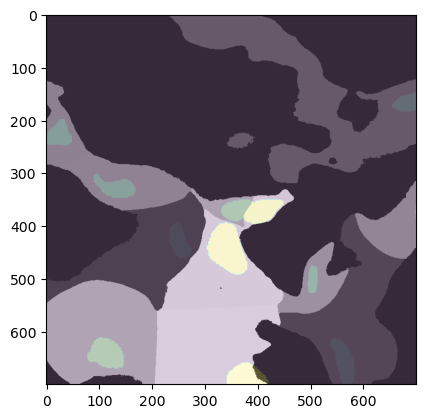

In [22]:
plt.imshow(np.amax(ind_cyto, 0), cmap = 'gist_gray', alpha = 0.8)
plt.imshow(np.amax(mask_nuclei, 0), alpha = 0.2)

## Simulate transcriptomic profile 

In [23]:
ref_anndata = scanpy.read('/media/tom/T7/simulation/test_set_simulation/test_anndata.h5ad')
ref_anndata

AnnData object with n_obs × n_vars = 4000 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'project', 'experiment', 'singlecell_version', 'sexe', 'genotype', 'IRstatus', 'IRdose', 'timepoint', 'sorted', 'condition', 'percent.mt', 'nCount_RNAraw', 'nFeature_RNAraw', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'cell_ID', 'sub_cell_ID', 'family', 'sub_family'
    var: 'features'

In [27]:
ref_anndata.X =ref_anndata.X.toarray()


In [30]:
path_to_save_anndata = "/media/tom/T7/simulation/test_set_simulation/anndata/"
path_to_save_df = "/media/tom/T7/simulation/test_set_simulation/dataframe/"
list_anndata = []
for path_ic in Path(path_save_ind_cyto).glob("*.npy"):
    
    ind_cyto = np.load(path_ic)
    
    anndata, df_spots = sim_spots_from_ref_anndata(

    ref_anndata = ref_anndata,
    ind_cyto = ind_cyto,
    image_name = 'test', 
    annotation_column = "cell_ID",
    selected_gene = selected_gene,
    remove_neighbors = True,
    max_dist = 0.3,
    dict_scale = {"x":0.103, 'y':0.103, "z":0.300},
        )
    
    list_anndata.append(anndata)
        
    anndata.write_h5ad(str(Path(path_to_save_anndata) /(path_ic.stem + '.h5ad')))
    df_spots.to_csv(Path(path_to_save_df) /(path_ic.stem + '.npy'))                   

View of AnnData object with n_obs × n_vars = 19 × 34
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'project', 'experiment', 'singlecell_version', 'sexe', 'genotype', 'IRstatus', 'IRdose', 'timepoint', 'sorted', 'condition', 'percent.mt', 'nCount_RNAraw', 'nFeature_RNAraw', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'cell_ID', 'sub_cell_ID', 'family', 'sub_family'
    var: 'features'
View of AnnData object with n_obs × n_vars = 12 × 34
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'project', 'experiment', 'singlecell_version', 'sexe', 'genotype', 'IRstatus', 'IRdose', 'timepoint', 'sorted', 'condition', 'percent.mt', 'nCount_RNAraw', 'nFeature_RNAraw', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'cell_ID', 'sub_cell_ID', 'family', 'sub_family'
    var: 'features'


In [38]:
anndata.var.features

Atp6v0d2    Atp6v0d2
Abcg1          Abcg1
Rtkn2          Rtkn2
Igfbp2        Igfbp2
Sftpc          Sftpc
Cxcl15        Cxcl15
Cd79a          Cd79a
Ms4a2          Ms4a2
Fcer1a        Fcer1a
Ccdc153      Ccdc153
Scgb3a2      Scgb3a2
Scgb1a1      Scgb1a1
Cst3            Cst3
Cdh5            Cdh5
Clec14a      Clec14a
Inmt            Inmt
Pcolce2      Pcolce2
C1qc            C1qc
C1qa            C1qa
C1qb            C1qb
Upk3b          Upk3b
Ifitm6        Ifitm6
Plac8          Plac8
Ms4a4b        Ms4a4b
Ccl5            Ccl5
Hcst            Hcst
Gzma            Gzma
Ncr1            Ncr1
S100a9        S100a9
Mmrn1          Mmrn1
Acta2          Acta2
Myh11          Myh11
Cd3g            Cd3g
Cd3d            Cd3d
Name: features, dtype: object

In [39]:
 ad.concat(list_anndata).var.features

/home/tom/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AttributeError: 'DataFrame' object has no attribute 'features'

In [ ]:
ref_anndata = ref_anndata
ind_cyto = ind_cyto
image_name = 'test' 
annotation_column = "cell_ID",
selected_gene = selected_gene,
remove_neighbors = True,
max_dist = 0.3,
dict_scale = {"x":0.103, 'y':0.103, "z":0.300},

### PLOT FINAL SIMULATION 

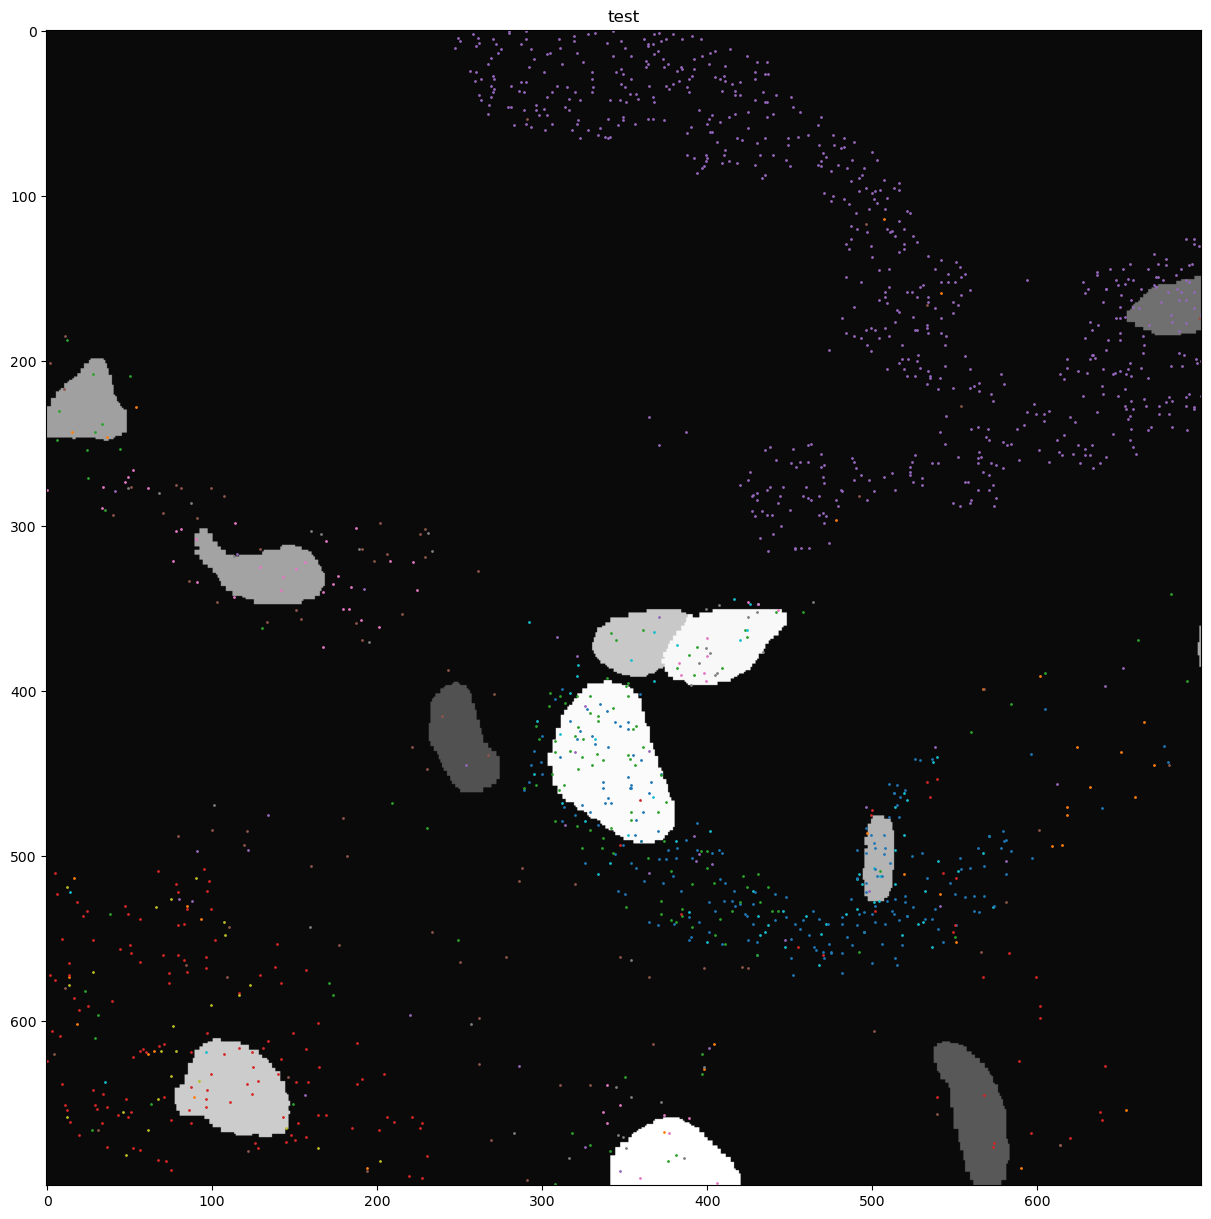

In [89]:
from matplotlib import colors

df_spots = pd.read_csv(Path(path_to_save_df) /(path_ic.stem + '.npy'))
mask_nuclei = tifffile.imread(Path(path_folder_mask_nuclei) / (path_ic.stem + '.tiff'))[20:30, :700, :700]
mip_nuclei = np.amax(mask_nuclei, 0)

dico_spots_pos = {}
for gene in selected_gene:
    y = df_spots[df_spots["gene"] == gene]["y"]
    x = df_spots[df_spots["gene"] == gene]["x"]

    dico_spots_pos[gene] = list(zip( y, x))
    

fig, ax = plt.subplots(figsize = (15,15))
#list_cmap1=colors.ListedColormap(list_markers_hardcoded.list_cmap1)
#ax.imshow(labelize_mask_true[0] , cmap=colors.ListedColormap(['k', 'k', '#fc8d59','#ffffbf','#91bfdb']))
ax.imshow(mip_nuclei > 0, cmap='gist_gray', alpha = 0.8)
ax.imshow(mip_nuclei, cmap='gist_gray', alpha = 0.8)
for gene in dico_spots_pos.keys():
    if len(dico_spots_pos[gene]) == 0:
        continue
    ax.scatter(np.array(dico_spots_pos[gene])[:,1], np.array(dico_spots_pos[gene])[:,0], cmap="Pastel1",  #  gene_color_dico[gene],   #'#%02X%02X%02X' % (r(),r(),r()),
               s=1)
plt.title(image_name)
plt.show()